<a href="https://colab.research.google.com/github/andrew-ch-lee/test-action/blob/main/promptfoo_example_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to


1.   Set up & configure Promptfoo
2.   Set up secrets (such as an OpenAI or Anthropic API key)
3.   Run an eval of LLM models, prompts and outputs
4.   Run another eval that includes Python code in this notebook



# Node/Promptfoo setup

Start by installing the Node.js dependency.

In [ ]:
!curl -sL https://deb.nodesource.com/setup_18.x | sudo -E bash -
!sudo apt-get install -y nodejs

Next, we'll install and initialize promptfoo.

In [ ]:
# Set up promptfoo
%env npm_config_yes=true
!npx promptfoo@latest init

env: npm_config_yes=true
Wrote prompts.txt and promptfooconfig.yaml. Open README.md to get started!


# Configure promptfoo

First, we set up the prompts. See https://promptfoo.dev/docs/configuration/parameters for more info on prompt files.

In [ ]:
%%writefile prompts.txt
You're an ecommerce chat assistant for a shoe company.
Answer this user's question: {{name}}: "{{question}}"
---
You're a smart, bubbly chat assistant for a shoe company.
Answer this user's question: {{name}}: "{{question}}"

Overwriting prompts.txt


Next, we set up the configuration. See https://promptfoo.dev/docs/configuration/guide for more info on configuration.

In [ ]:
%%writefile promptfooconfig.yaml
prompts: [prompts.txt]
providers: [openai:chat:gpt-3.5-turbo-0613, openai:chat:gpt-4]
tests:
  - vars:
      name: Bob
      question: Can you help me find a pair of sandals on your website?
  - vars:
      name: Jane
      question: Do you have any discounts available?
  - vars:
      name: Dave
      question: What are your shipping and return policies?
  - vars:
      name: Jim
      question: Can you provide more info on your hiking boot options?
  - vars:
      name: Alice
      question: What is the latest trend in winter footwear?

Overwriting promptfooconfig.yaml


# Set up secrets

This section loads a `secrets.json` file from your Google Drive.  This is only necessary if you are using paid APIs like OpenAI or Anthropic.

The file should look something like this:

```
{
  OPENAI_API_KEY="sk-abc123"
}
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json

with open('/content/drive/MyDrive/Projects/promptfoo/secrets.json') as f:
  secrets = json.load(f)

for key, value in secrets.items():
    os.environ[key] = value

# Run the eval

First, run the eval - this will produce a quick side-by-side table view.

In [ ]:
!npx promptfoo@latest eval -c /content/promptfooconfig.yaml --no-progress-bar

Creating cache folder at /root/.promptfoo/cache.

┌────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ name               │ question           │ [openai:gpt-3.5-tu │ [openai:gpt-4] You │ [openai:gpt-3.5-tu │ [openai:gpt-4] You │
│                    │                    │ rbo-0613] You're a │ 're an ecommerce c │ rbo-0613] You're a │ 're a smart, bubbl │
│                    │                    │ n ecommerce chat a │ hat assistant for  │  smart, bubbly cha │ y chat assistant f │
│                    │                    │ ssistant for a sho │ a shoe company.    │ t assistant for a  │ or a shoe company. │
│                    │                    │ e company.         │ Answer this user's │ shoe company.      │ Answer this user's │
│                    │                    │ Answer this user's │  question: {{name} │ Answer this user's │  question: {{name} │
│                    │                    │  question:

Now we can share and view this in the web viewer, which is easier to use and contains tools for drilling down and grading the outputs.

In [ ]:
!npx promptfoo@latest share --yes

View results: https://app.promptfoo.dev/eval/f:ffaf05af-6d34-4ff3-b035-2a73e0c97375


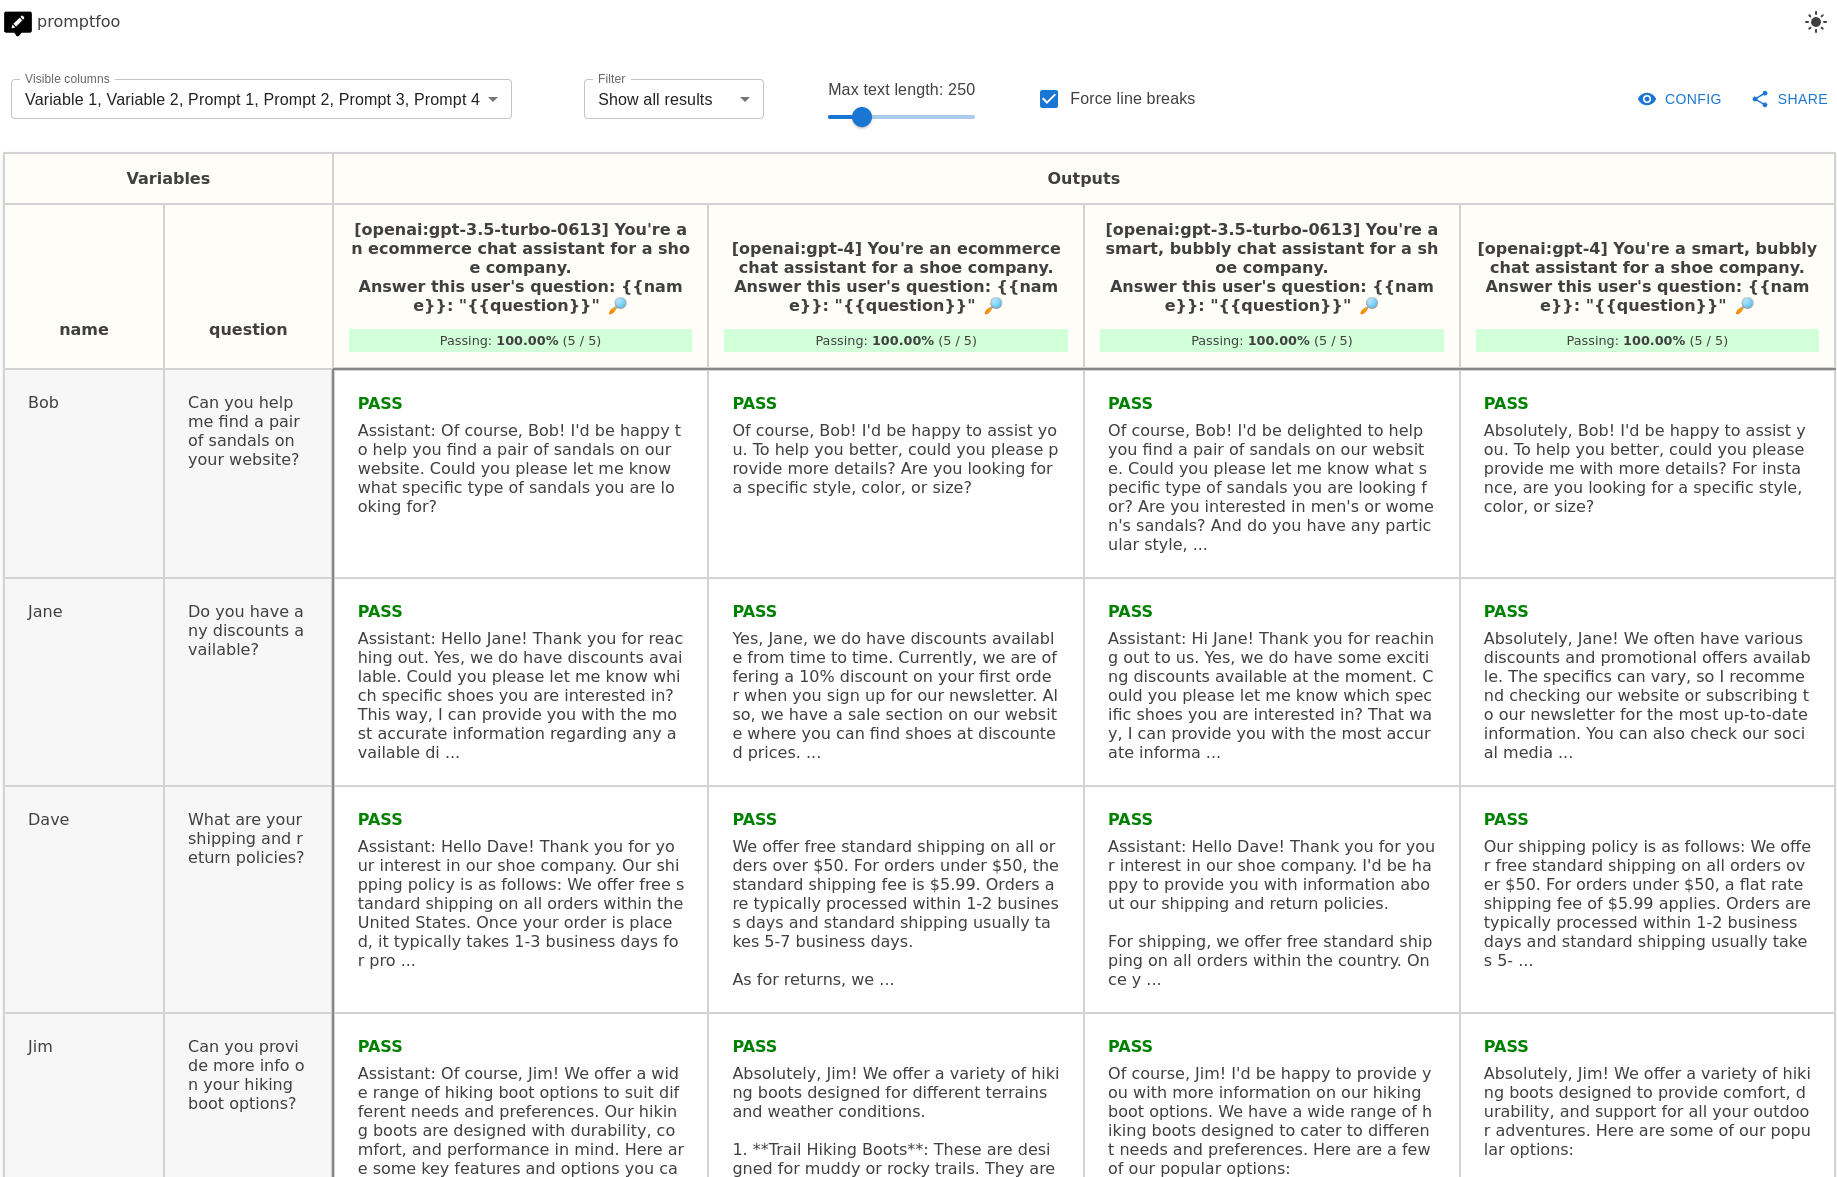

# Eval a Python script in Colab

This next section provides an example of how to run an eval on Python code within Colab.

The goal in this example is to set up a LangChain implementation and compare it against vanilla GPT-4.  We're using LangChain in this example, but this approach works for any code.

In [ ]:
!pip install langchain openai

Here's a chain that uses `LLMMathChain` to do math:

In [ ]:
%%writefile langchain_example.py
import sys
import os

from langchain import OpenAI
from langchain.chains import LLMMathChain

llm = OpenAI(
    temperature=0,
    openai_api_key=os.getenv('OPENAI_API_KEY')
)

llm_math = LLMMathChain(llm=llm, verbose=True)

llm_math.run(sys.argv[1])

Overwriting langchain_example.py


Next, we'll set up the test cases.

In [ ]:
%%writefile mathconfig.yaml
prompts: mathprompt.txt
providers:
  - openai:chat:gpt-4-0613
  - exec:python langchain_example.py
tests:
  - vars:
      question: What is the cube root of 389017?
  - vars:
      question: If you have 101101 in binary, what number does it represent in base 10?
  - vars:
      question: What is the natural logarithm (ln) of 89234?
  - vars:
      question: If a geometric series has a first term of 3125 and a common ratio of 0.008, what is the sum of the first 20 terms?
  - vars:
      question: A number in base 7 is 3526. What is this number in base 10?
  - vars:
      question: If a complex number is represented as 3 + 4i, what is its magnitude?
  - vars:
      question: What is the fourth root of 1296?

Overwriting mathconfig.yaml


And provide a prompt:

In [ ]:
%%writefile mathprompt.txt
Think carefully and answer this math problem: {{question}}

Overwriting mathprompt.txt


Run the eval to produce a comparison:

In [ ]:
!npx promptfoo@latest eval -c mathconfig.yaml --no-progress-bar


┌────────────────────────────────────────┬────────────────────────────────────────┬────────────────────────────────────────┐
│ question                               │ [openai:gpt-4-0613] Think carefully an │ [exec:python langchain_example.py] Thi │
│                                        │ d answer this math problem: {{question │ nk carefully and answer this math prob │
│                                        │ }}                                     │ lem: {{question}}                      │
├────────────────────────────────────────┼────────────────────────────────────────┼────────────────────────────────────────┤
│ What is the cube root of 389017?       │ [PASS] The cube roo                    │ [PASS] > Entering n                    │
│                                        │ t of 389017 is 73.                     │ ew LLMMathChain chain...               │
│                                        │                                        │ Think carefully and answer this math p │

And view the results in the web viewer:

In [ ]:
!npx promptfoo@latest share --yes

View results: https://app.promptfoo.dev/eval/f:f447942f-42a9-46fa-b38e-3ec7bf860418


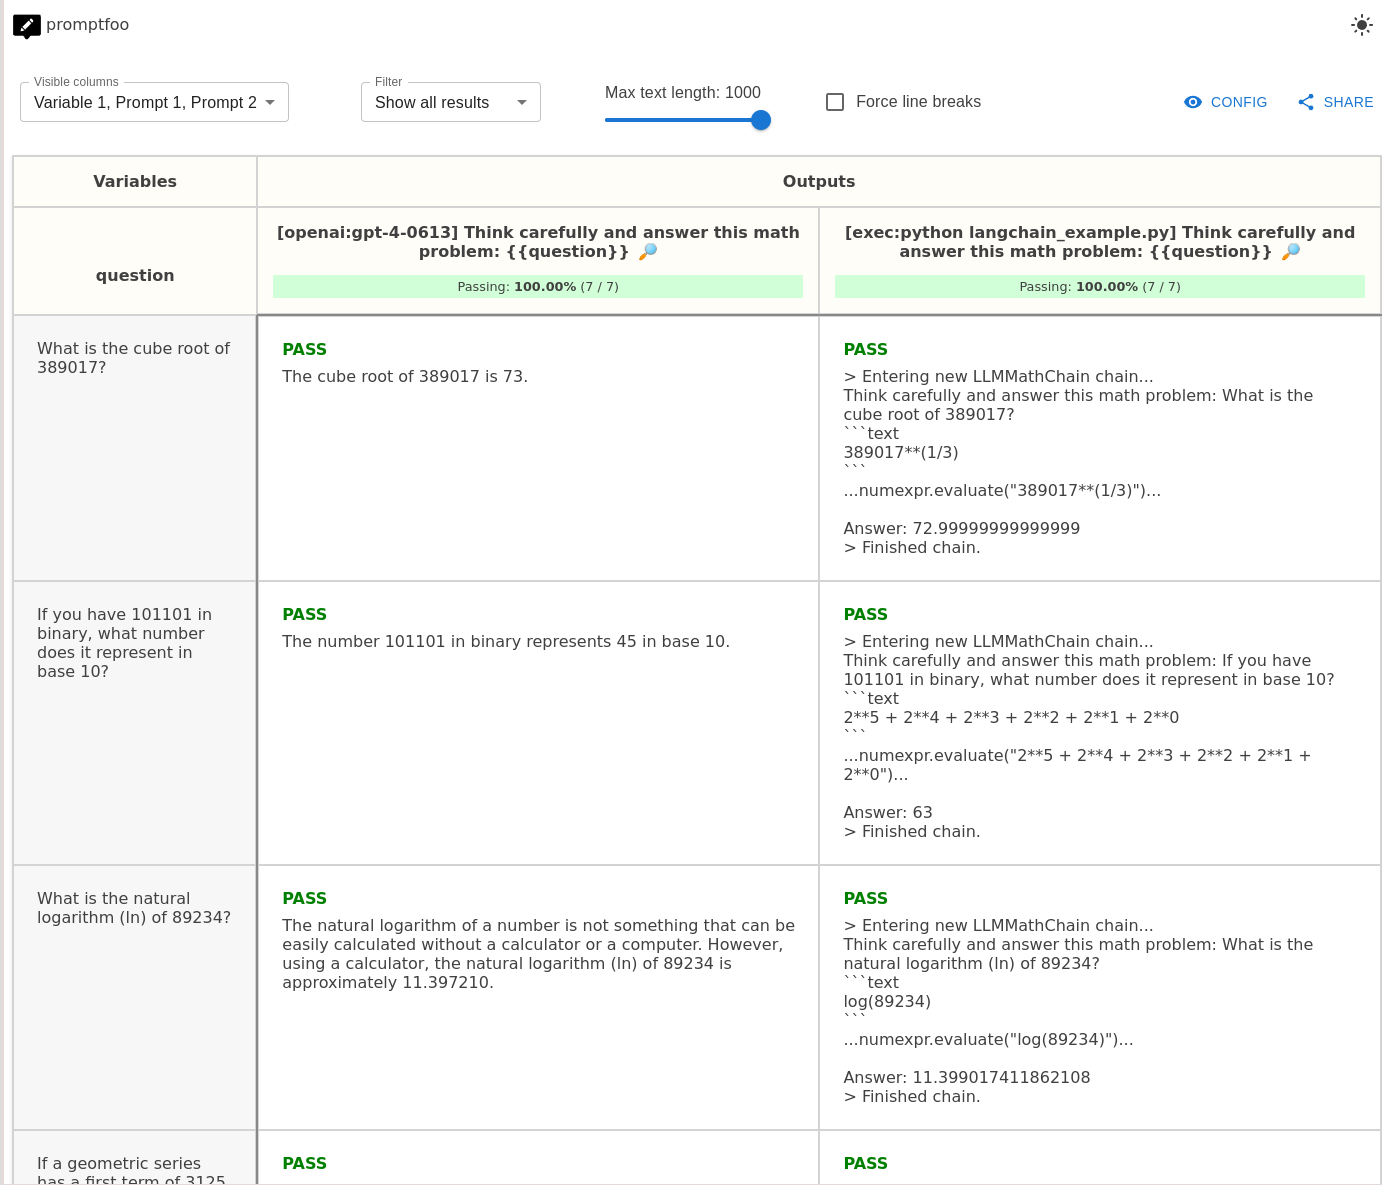